# FORCE learning with spikes

This notebook demonstrates how to implement both full-FORCE [1] and "Classic FORCE" [2] networks in Nengo. This makes it "trivial" to switch between neuron models (rate-based, spiking, adaptive, etc.), and to explore the effects of different learning rules and architectural assumptions.

For this demonstration, we use recursive least-squares (RLS) learning, with spiking `LIF` neurons, and the two basic architectures (full-FORCE and classic-FORCE) -- to learn a bandpass filter (a.k.a. a "decaying oscillator" triggered by unit impulses).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import nengo
from nengo.learning_rules import RLS

In [2]:
# Task parameters
pulse_interval = 1.0
amplitude = 0.1
freq = 3.0
decay = 2.0
dt = 0.002
trials_train = 3
trials_test = 2

# Fixed model parameters
n = 200
seed = 0
rng = np.random.RandomState(seed)
ens_kwargs = dict(  # neuron parameters
    n_neurons=n,
    dimensions=1,
    neuron_type=nengo.LIF(),  # nengolib.neurons.Tanh()
    intercepts=[-1] * n,  # intercepts are irelevant for Tanh
    seed=seed,
)

# Hyper-parameters
tau = 0.1  # lowpass time-constant (10ms in [1])
tau_learn = 0.1  # filter for error / learning (needed for spiking)
tau_probe = 0.05  # filter for readout (needed for spiking
learning_rate = 0.1  # 1 in [1]
g = 1.5 / 400  # 1.5 in [1], scaled by firing rates
g_in = tau / amplitude  # scale the input encoders (usually 1)
g_out = 1.0  # scale the recurrent encoders (usually 1)

# Pre-computed constants
T_train = trials_train * pulse_interval
T_total = (trials_train + trials_test) * pulse_interval

In [3]:
with nengo.Network(seed=seed) as model:
    # Input is a pulse every pulse_interval seconds
    U = np.zeros(int(pulse_interval / dt))
    U[0] = amplitude / dt
    u = nengo.Node(output=nengo.processes.PresentInput(U, dt))

    # Desired output is a decaying oscillator
    z = nengo.Node(size_in=1)
    nengo.Connection(u, z, synapse=nengo.synapses.Bandpass(freq, decay))

# Initial weights
e_in = g_in * rng.uniform(-1, +1, (n, 1))  # fixed encoders for f_in (u_in)
e_out = g_out * rng.uniform(-1, +1, (n, 1))  # fixed encoders for f_out (u)
JD = rng.randn(n, n) * g / np.sqrt(n)  # target-generating weights (variance g^2/n)

## Classic FORCE

 - `xC` are the neurons
 - `sC` are the unfiltered currents into each neuron (`sC -> Lowpass(tau) -> xC`)
 - `zC` is the learned output estimate, decoded by the neurons, and re-encoded back into `sC` alongside some random feedback (`JD`)
 - `eC` is a gated error signal for RLS that turns off after `T_train` seconds. This error signal learns the feedback decoders by minmizing the difference between `z` (ideal output) and `zC` (actual output).

The error signal driving RLS has an additional filter applied (`tau_learn`) to handle the case when this signal consists of spikes (not rates).

In [4]:
with model:
    xC = nengo.Ensemble(**ens_kwargs)
    sC = nengo.Node(size_in=n)  # pre filter
    eC = nengo.Node(size_in=1, output=lambda t, e: e if t < T_train else 0)
    zC = nengo.Node(size_in=1)  # learned output

    nengo.Connection(u, sC, synapse=None, transform=e_in)
    nengo.Connection(sC, xC.neurons, synapse=tau)
    nengo.Connection(xC.neurons, sC, synapse=None, transform=JD)  # chaos
    connC = nengo.Connection(
        xC.neurons,
        zC,
        synapse=None,
        transform=np.zeros((1, n)),
        learning_rule_type=RLS(learning_rate=learning_rate, pre_synapse=tau_learn),
    )
    nengo.Connection(zC, sC, synapse=None, transform=e_out)

    nengo.Connection(zC, eC, synapse=None)  # actual
    nengo.Connection(z, eC, synapse=None, transform=-1)  # ideal
    nengo.Connection(eC, connC.learning_rule, synapse=tau_learn)

## full-FORCE


![full-FORCE Figure 1](http://journals.plos.org/plosone/article/figure/image?size=large&id=info:doi/10.1371/journal.pone.0191527.g001)
<div align="center"><b>Figure 1.</b> Network architecture from [1].</div>

### Target-Generating Network

See Fig 1b.

 - `xD` are the neurons that behave like classic FORCE in the ideal case (assuming the ideal output `z` is perfectly re-encoded)
 - `sD` are the unfiltered currents into each neuron (`sD -> Lowpass(tau) -> xD`)

In [5]:
with model:
    xD = nengo.Ensemble(**ens_kwargs)
    sD = nengo.Node(size_in=n)  # pre filter

    nengo.Connection(u, sD, synapse=None, transform=e_in)
    nengo.Connection(z, sD, synapse=None, transform=e_out)
    nengo.Connection(sD, xD.neurons, synapse=tau)
    nengo.Connection(xD.neurons, sD, synapse=None, transform=JD)

### Task-Performing Network

See Fig 1a.

 - `xF` are the neurons
 - `sF` are the unfiltered currents into each neuron (`sF -> Lowpass(tau) -> xF`)
 - `eF` is a gated error signal for RLS that turns off after `T_train` seconds. This error signal learns the full-rank feedback weights by minimizing the difference between the unfiltered currents `sD` and `sF`.

The error signal driving RLS also has the same filter applied (`tau_learn`) to handle spikes. The output estimate is trained offline from the entire training set using batched least-squares, since this gives the best performance.

In [6]:
with model:
    xF = nengo.Ensemble(**ens_kwargs)
    sF = nengo.Node(size_in=n)  # pre filter
    eF = nengo.Node(
        size_in=n, output=lambda t, e: e if t < T_train else np.zeros_like(e)
    )

    nengo.Connection(u, sF, synapse=None, transform=e_in)
    nengo.Connection(sF, xF.neurons, synapse=tau)
    connF = nengo.Connection(
        xF.neurons,
        sF,
        synapse=None,
        transform=np.zeros((n, n)),
        learning_rule_type=RLS(learning_rate=learning_rate, pre_synapse=tau_learn),
    )

    nengo.Connection(sF, eF, synapse=None)  # actual
    nengo.Connection(sD, eF, synapse=None, transform=-1)  # ideal
    nengo.Connection(eF, connF.learning_rule, synapse=tau_learn)

## Results

In [7]:
with model:
    # Probes
    p_z = nengo.Probe(z, synapse=tau_probe)
    p_zC = nengo.Probe(zC, synapse=tau_probe)
    p_xF = nengo.Probe(xF.neurons, synapse=tau_probe)

with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T_total)

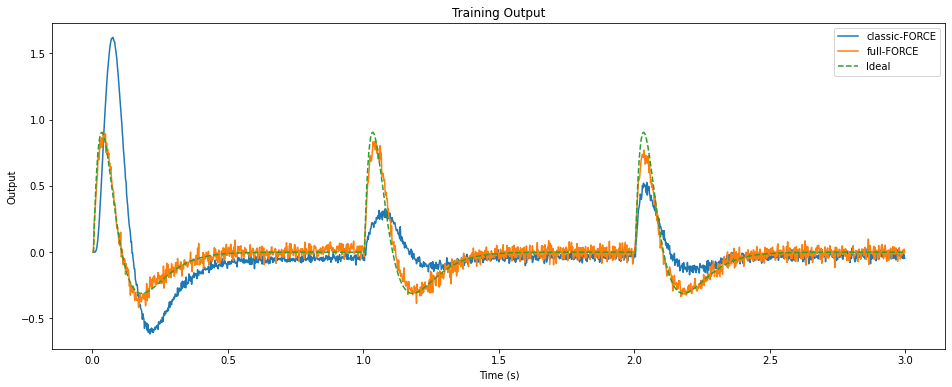

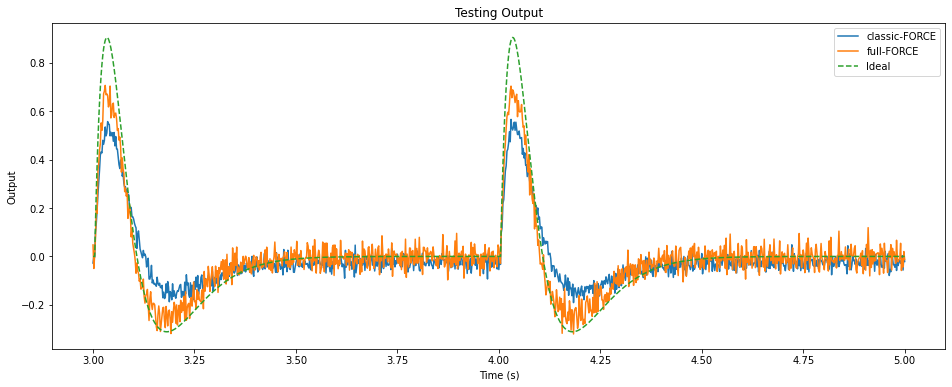

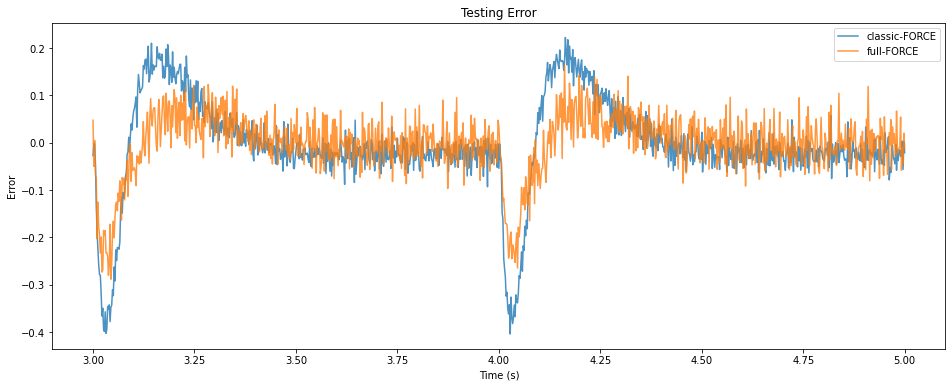

In [8]:
# We do the readout training for full-FORCE offline, since this gives better
# performance without affecting anything else
t_train = sim.trange() < T_train
t_test = sim.trange() >= T_train

solver = nengo.solvers.LstsqL2(reg=1e-2)
wF, _ = solver(sim.data[p_xF][t_train], sim.data[p_z][t_train])
zF = sim.data[p_xF].dot(wF)

plt.figure(figsize=(16, 6))
plt.title("Training Output")
plt.plot(sim.trange()[t_train], sim.data[p_zC][t_train], label="classic-FORCE")
plt.plot(sim.trange()[t_train], zF[t_train], label="full-FORCE")
plt.plot(sim.trange()[t_train], sim.data[p_z][t_train], label="Ideal", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()

plt.figure(figsize=(16, 6))
plt.title("Testing Output")
plt.plot(sim.trange()[t_test], sim.data[p_zC][t_test], label="classic-FORCE")
plt.plot(sim.trange()[t_test], zF[t_test], label="full-FORCE")
plt.plot(sim.trange()[t_test], sim.data[p_z][t_test], label="Ideal", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()

plt.figure(figsize=(16, 6))
plt.title("Testing Error")
plt.plot(
    sim.trange()[t_test],
    sim.data[p_zC][t_test] - sim.data[p_z][t_test],
    alpha=0.8,
    label="classic-FORCE",
)
plt.plot(
    sim.trange()[t_test],
    zF[t_test] - sim.data[p_z][t_test],
    alpha=0.8,
    label="full-FORCE",
)
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.legend()

## References

[1] DePasquale, B., Cueva, C. J., Rajan, K., & Abbott, L. F. (2018). full-FORCE: A target-based method for training recurrent networks. PloS one, 13(2), e0191527. http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0191527

[2] Sussillo, D., & Abbott, L. F. (2009). Generating coherent patterns of activity from chaotic neural networks. Neuron, 63(4), 544-557. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2756108/